In [1]:
source("../../BrusselSprouts/scripts/functions.R")
scripts_dir="/home/jnrunge/data/trd/mapped_reads/scripts/"
initial_timedate=Sys.time()
library(tidytable)


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


This can lead to most dplyr functions being overwritten by tidytable functions.


Attaching package: 'tidytable'


The following objects are masked from 'package:dplyr':

    across, add_count, add_tally, anti_join, arrange, between,
    bind_cols, bind_rows, c_across, case_match, case_when, coalesce,
    consecutive_id, count, cross_join, cume_dist, cur_column, cur_data,
    cur_group_id, cur_group_rows, dense_rank, desc, distinct, filter,
    first, full_join, group_by, group_cols, group_split, group_vars,
    if_all, if_any, if_else, inner_join, is_grouped_df, lag, last,
    lead, left_join, min_rank, mutate, n, n_distinct, na_if, nest_by,
    nest_join, nth, percent_rank, pick, pull, recode, reloca

In [2]:
options(repr.plot.width=10, repr.plot.height=5)

In [3]:
selectSimilarity=0.7

In [4]:
df_Strains=fread("../Shiny/data/Victor/operationalTable_Full2543Sace_Clades.csv")

In [5]:
crosses=readLines("~/data/trd/mapped_reads/TRD.vcf.gz.samples")
crosses=crosses[startsWith(crosses, "YJNRC") | startsWith(crosses, "Chris")]
crosses

[1] "ChrisC1" "ChrisC2" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC6" "ChrisC7"
 [8] "ChrisC8" "YJNRC1"  "YJNRC11" "YJNRC12" "YJNRC14" "YJNRC15" "YJNRC16"
[15] "YJNRC17" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21" "YJNRC22"
[22] "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29" "YJNRC3" 
[29] "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC34" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[36] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [6]:
file_a_exists_and_is_newer_than_file_b=function(a,b){
    if(file.exists(a)){
        if(file.mtime(a)>file.mtime(b)){
            return(TRUE)
        }
    }
    return(FALSE)
}

In [15]:
file.mtime(AS_file)

[1] NA

In [18]:
pixy_files=list.files(path = "~/data/trd/mapped_reads", pattern=paste0(c,"_",i,".*pixy.*txt.gz$"), full.names = TRUE)
pixy_files=pixy_files[file.mtime(pixy_files)>file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))]
pixy_files

character(0)

In [ ]:
# cell below the next needs to be merged with this here to only show the new comparison

In [10]:
for(c in crosses){
    print(c)
    
    TRD_regions_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz")
    AS_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz")
    TRD_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz")
    
        if(!file_a_exists_and_is_newer_than_file_b(TRD_file,"~/data/trd/mapped_reads/TRD.vcf.gz")){
        print(paste0(c, " TRD file does not exist or is not newer than TRD.vcf.gz"))
        next
    }
    
    if(!file_a_exists_and_is_newer_than_file_b(TRD_regions_file,TRD_file)){
        print(paste0(c, " has no TRD regions or no up-to-date ones"))
        next
    }
    if(!file_a_exists_and_is_newer_than_file_b(AS_file,TRD_file)){
        print(paste0(c, " has no or no updated allele sharing file"))
        next
    }
    
    pixy_files_all=list.files(path = "~/data/trd/mapped_reads", pattern=paste0(c,"_.*pixy.*txt.gz$"), full.names = TRUE)
    
    if(length(pixy_files_all)==0){
        print(paste(c, " has no pixy files."))
        next
    }

    AS=fread(AS_file)

    TRD=fread(TRD_file)

    TRD_loci=fread(TRD_regions_file)
    
    


    for(i in 1:nrow(TRD_loci)){
        
        pixy_files=list.files(path = "~/data/trd/mapped_reads", pattern=paste0(c,"_",i,".*pixy.*txt.gz$"), full.names = TRUE)
        pixy_files=pixy_files[file.mtime(pixy_files)>file.mtime(AS_file)]
        if(length(pixy_files)!=(16*3)){
            print(paste0(c, " with TRD ",i," has no or not enough or not updated pixy files :("))
            next
        }


        if(TRD_loci$chr_start[i]!=TRD_loci$chr_end[i]){
            stop("chr overlapping TRD")
        }
        TRD_subset=filter(TRD, chr== TRD_loci$chr_start[i] & global_pos >= TRD_loci$global_start[i] & global_pos <= TRD_loci$global_end[i])
        df_AS_filtered=filter(AS, `#CHROM` == TRD_loci$chr_start[i], POS %in% TRD_subset$pos)
        melted=reshape2::melt(df_AS_filtered, id.vars = c("#CHROM","POS"))
        melted=filter(melted, variable != "chrpos")
        tmp=summarise(group_by(melted, variable), nAll=n())
        vcf_translated_summary=left_join(tmp,summarise(group_by(melted, variable, value), n=n()), by=c("variable"))%>%mutate(p=n/nAll)%>%select(variable,value,p)%>%rename(Strain=variable, Type=value)
        A1s=vcf_translated_summary$Strain[vcf_translated_summary$Type=="A1_hom" & vcf_translated_summary$p>=selectSimilarity]
        A2s=vcf_translated_summary$Strain[vcf_translated_summary$Type=="A2_hom" & vcf_translated_summary$p>=selectSimilarity]
        pop_summary=bind_rows(summarise(group_by(filter(df_Strains, StandardizedName %in% A1s),
                               Clade), n=n()) %>% arrange(-n)%>%mutate(Type="A1_hom"),
                      summarise(group_by(filter(df_Strains, StandardizedName %in% A2s),
                                         Clade), n=n()) %>% arrange(-n)%>%mutate(Type="A2_hom"))%>% arrange(-n)
        pop_summary

        if(mean(TRD_subset$AD_A1/TRD_subset$sumCount)<0.5){
            distorter="A2"
            nondistorter="A1"
        }else{
            distorter="A1"
            nondistorter="A2"}

        pop_summary=filter(pop_summary, !is.na(Clade))
        pop_summary=mutate(pop_summary, Clade=gsub("[ .]","_",Clade))

        pop_summary$Type2=NA
        pop_summary$Type2[pop_summary$Type==paste0(distorter,"_hom")]="Distorter-like"
        pop_summary$Type2[pop_summary$Type==paste0(nondistorter,"_hom")]="Non-distorter-like"

        

        pixy_pi=fread_and_bind_files(pixy_files[grepl("_pi.txt",pixy_files,fixed=TRUE)])
        setDT(pixy_pi)
        pixy_dxy=fread_and_bind_files(pixy_files[grepl("_dxy.txt",pixy_files,fixed=TRUE)])
        setDT(pixy_dxy)
        pixy_fst=fread_and_bind_files(pixy_files[grepl("_fst.txt",pixy_files,fixed=TRUE)])
        setDT(pixy_fst)

        pixy_pi=arrange(pixy_pi, pop)


        pop_summary=arrange(pop_summary, Clade)

        pop_summary$color=NA
        pop_summary$color[pop_summary$Type2=="Distorter-like"]=colorRampPalette(c("#FFC4CB","#8B0000"))(sum(pop_summary$Type2=="Distorter-like"))
        pop_summary$color[pop_summary$Type2=="Non-distorter-like"]=colorRampPalette(c("#ADD8E6","#00008B"))(sum(pop_summary$Type2=="Non-distorter-like"))

        pop_summary

        # pop_summary is not used when distorter vs others is done 

        pixy_pi$pop_fct=factor(pixy_pi$pop, levels=pop_summary$Clade)

        # not used when only two groups


        p<-ggplot(filter(pixy_pi, chromosome == TRD_loci$chr_start[i]), aes(avg_pi*100,fill=pop))+
        geom_histogram(binwidth=0.05,alpha=1)+scale_x_log10(breaks=c(0.0001,0.001,0.01)*100, labels=c(0.0001,0.001,0.01), minor_breaks=seq(from=0,to=1*100,by=0.001*100))+
        #scale_color_manual(values=pop_summary$color)+
        #scale_fill_manual(values=pop_summary$color)+
        scale_color_manual(values=c("distorter-like"="red", "other"="blue"))+
        scale_fill_manual(values=c("distorter-like"="red", "other"="blue"))+
        #geom_vline(data=filter(pixy_pi, chromosome == TRD_loci$chr_start[i], pop%in%pop_summary$Clade,
        #                              (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
        #                               (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
        #                               (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos)))%>%  group_by(pop) %>% #summarise(mean_pi=mean(avg_pi)),
        #           mapping=aes(xintercept=mean_pi*100), size=3.5,color="black")+
        geom_segment(data=filter(pixy_pi, chromosome == TRD_loci$chr_start[i],
                                      (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
                                       (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
                                       (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos)))%>%  group_by(pop) %>% summarise(mean_pi=mean(avg_pi)),
                   mapping=aes(x=mean_pi*100, xend=mean_pi*100, y=-1, yend=-10, color=pop), linewidth=3)+theme_bw(18)+xlab("Nucleotide diversity")+ylab(NULL)

        print(p)

        options(repr.plot.width=10, repr.plot.height=5)

        p<-ggplot(pixy_pi, aes(avg_pi*100,fill=pop))+
        geom_histogram(binwidth=0.05,alpha=1)+scale_x_log10(breaks=c(0.0001,0.001,0.01)*100, labels=c(0.0001,0.001,0.01), minor_breaks=seq(from=0,to=1*100,by=0.001*100))+
        #scale_color_manual(values=pop_summary$color)+
        #scale_fill_manual(values=pop_summary$color)+
        scale_color_manual(values=c("distorter-like"="red", "other"="blue"))+
        scale_fill_manual(values=c("distorter-like"="red", "other"="blue"))+
        #geom_vline(data=filter(pixy_pi, chromosome == TRD_loci$chr_start[i], pop%in%pop_summary$Clade,
        #                              (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
        #                               (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
        #                               (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos)))%>%  group_by(pop) %>% #summarise(mean_pi=mean(avg_pi)),
        #           mapping=aes(xintercept=mean_pi*100), size=3.5,color="black")+
        geom_segment(data=filter(pixy_pi, chromosome == TRD_loci$chr_start[i],
                                      (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
                                       (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
                                       (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos)))%>%  group_by(pop) %>% summarise(mean_pi=mean(avg_pi)),
                   mapping=aes(x=mean_pi*100, xend=mean_pi*100, y=-1, yend=-10, color=pop), linewidth=3)+theme_bw(18)+xlab("Nucleotide diversity")+ylab(NULL)

        print(p)

        # code below works for 1 (!) distorter-like pop

        sum_fst_chr<-summarise(group_by(filter(pixy_fst, chromosome == TRD_loci$chr_start[i], 
            #                                   pop1%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"] | 
            #   pop2%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"]
                                              ),
                                        pop1, pop2), mean_fst_chr=mean(avg_wc_fst,na.rm=TRUE))


        sum_fst_TRD<-summarise(group_by(filter(pixy_fst, chromosome == TRD_loci$chr_start[i], 
                                               #pop1%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"] | 
               #pop2%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"],
                                      (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
                                       (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
                                       (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos))), pop1, pop2), mean_fst_TRD=mean(avg_wc_fst,na.rm=TRUE))

        sum_fst=full_join(sum_fst_chr,sum_fst_TRD)

        sum_fst_melt=reshape2::melt(sum_fst, measure.vars=c("mean_fst_TRD","mean_fst_chr"))
        sum_fst_melt

        p<-ggplot(pixy_fst, aes(avg_wc_fst))+
        geom_histogram()+geom_vline(xintercept = sum_fst_melt$value[sum_fst_melt$variable=="mean_fst_TRD"],color="red")+
        theme_bw(18)+ylab(NULL)+xlab("Fst")

        print(p)

        #sum_fst=left_join(sum_fst, mutate(pop_summary,pop1=Clade,color1=color)%>%select(pop1,color1))
        #sum_fst=left_join(sum_fst, mutate(pop_summary,pop2=Clade,color2=color)%>%select(pop2,color2))


        #sum_fst$color1[is.na(sum_fst$color1)]="grey"
        #sum_fst$color2[is.na(sum_fst$color2)]="grey"

        #etDF(sum_fst)
        #sum_fst$color=sum_fst$color1
        #sum_fst$color[sum_fst$pop1=="22__East_Asian_Wild"]=sum_fst$color2[sum_fst$pop1=="22__East_Asian_Wild"]
        #setDT(sum_fst)

        #ggplot(sum_fst, aes(mean_fst_TRD-mean_fst_chr))+
        #geom_histogram()+geom_vline(xintercept = 0)+#+scale_fill_manual(values=sum_fst$color)+
        #theme_bw(18)+ylab(NULL)+xlab("Fixation index (distorter vs other clades) in TRD region vs. rest of chr")+theme(legend.position="none")
        
        
        stop()
        }
    
}

[1] "ChrisC1"
[1] "ChrisC1 with TRD 1 has no or not enough or not updated pixy files :("
[1] "ChrisC1 with TRD 2 has no or not enough or not updated pixy files :("
[1] "ChrisC1 with TRD 3 has no or not enough or not updated pixy files :("
[1] "ChrisC1 with TRD 4 has no or not enough or not updated pixy files :("
[1] "ChrisC2"
[1] "ChrisC2 has no TRD regions or no up-to-date ones"
[1] "ChrisC3"
[1] "ChrisC3  has no pixy files."
[1] "ChrisC4"
[1] "ChrisC4  has no pixy files."
[1] "ChrisC5"
[1] "ChrisC5 TRD file does not exist or is not newer than TRD.vcf.gz"
[1] "ChrisC6"
[1] "ChrisC6 has no TRD regions or no up-to-date ones"
[1] "ChrisC7"
[1] "ChrisC7 with TRD 1 has no or not enough or not updated pixy files :("
[1] "ChrisC7 with TRD 2 has no or not enough or not updated pixy files :("
[1] "ChrisC7 with TRD 3 has no or not enough or not updated pixy files :("
[1] "ChrisC7 with TRD 4 has no or not enough or not updated pixy files :("
[1] "ChrisC7 with TRD 5 has no or not enough or not up

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 30 rows containing non-finite values (`stat_bin()`)."


pop1,pop2,variable,value
<chr>,<chr>,<fct>,<dbl>
other,distorter-like,mean_fst_TRD,0.6353453
other,distorter-like,mean_fst_chr,0.5721830


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


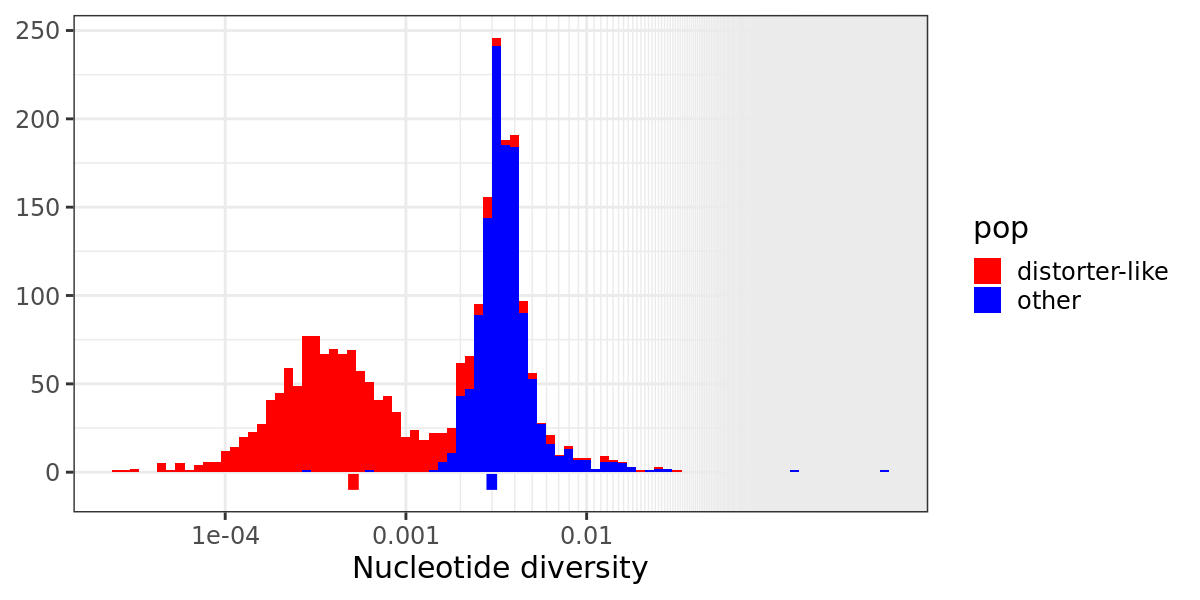

ERROR: Error in eval(expr, envir, enclos): 


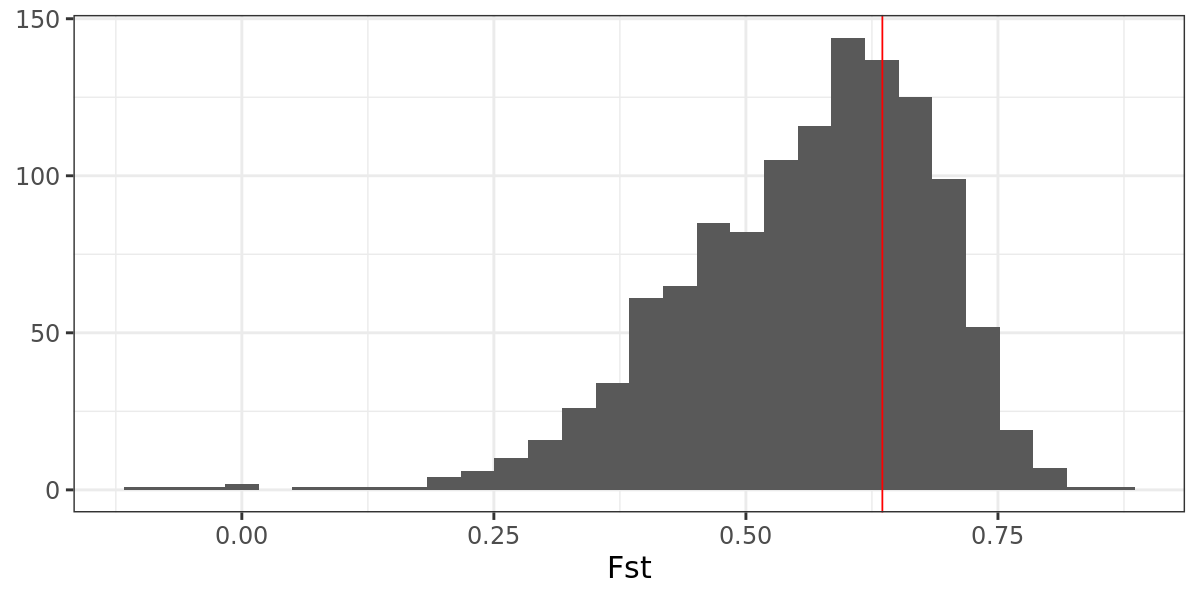

In [25]:
c="ChrisC7"
i=3
    
    TRD_regions_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz")
    AS_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz")
    TRD_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz")
    
        if(!file_a_exists_and_is_newer_than_file_b(TRD_file,"~/data/trd/mapped_reads/TRD.vcf.gz")){
        print(paste0(c, " TRD file does not exist or is not newer than TRD.vcf.gz"))
        next
    }
    
    if(!file_a_exists_and_is_newer_than_file_b(TRD_regions_file,TRD_file)){
        print(paste0(c, " has no TRD regions or no up-to-date ones"))
        next
    }
    if(!file_a_exists_and_is_newer_than_file_b(AS_file,TRD_file)){
        print(paste0(c, " has no or no updated allele sharing file"))
        next
    }
    
    pixy_files_all=list.files(path = "~/data/trd/mapped_reads", pattern=paste0(c,"_.*pixy.*txt.gz$"), full.names = TRUE)
    
    if(length(pixy_files_all)==0){
        print(paste(c, " has no pixy files."))
        next
    }

    AS=fread(AS_file)

    TRD=fread(TRD_file)

    TRD_loci=fread(TRD_regions_file)
    
    



        
        pixy_files=list.files(path = "~/data/trd/mapped_reads", pattern=paste0(c,"_",i,".*pixy.*txt.gz$"), full.names = TRUE)
        if(length(pixy_files)!=(16*3)){
            print(paste0(c, " with TRD ",i," has no or not enough or not updated pixy files :("))
            next
        }


        if(TRD_loci$chr_start[i]!=TRD_loci$chr_end[i]){
            stop("chr overlapping TRD")
        }
        TRD_subset=filter(TRD, chr== TRD_loci$chr_start[i] & global_pos >= TRD_loci$global_start[i] & global_pos <= TRD_loci$global_end[i])
        df_AS_filtered=filter(AS, `#CHROM` == TRD_loci$chr_start[i], POS %in% TRD_subset$pos)
        

        

        pixy_pi=fread_and_bind_files(pixy_files[grepl("_pi.txt",pixy_files,fixed=TRUE)])
        setDT(pixy_pi)
        pixy_dxy=fread_and_bind_files(pixy_files[grepl("_dxy.txt",pixy_files,fixed=TRUE)])
        setDT(pixy_dxy)
        pixy_fst=fread_and_bind_files(pixy_files[grepl("_fst.txt",pixy_files,fixed=TRUE)])
        setDT(pixy_fst)

        pixy_pi=arrange(pixy_pi, pop)






        pixy_pi$pop_fct=as.factor(pixy_pi$pop)
        pixy_pi$color=NA
pixy_pi$color[pixy_pi$pop=="distorter-like"]=colorRampPalette(c("#FFC4CB","#8B0000"))(1)
pixy_pi$color[pixy_pi$pop=="other"]=colorRampPalette(c("#ADD8E6","#00008B"))(1)
        

   

        options(repr.plot.width=10, repr.plot.height=5)

        p<-ggplot(pixy_pi, aes(avg_pi*100,fill=pop))+
        geom_histogram(binwidth=0.05,alpha=1)+scale_x_log10(breaks=c(0.0001,0.001,0.01)*100, labels=c(0.0001,0.001,0.01), minor_breaks=seq(from=0,to=1*100,by=0.001*100))+
        #scale_color_manual(values=pop_summary$color)+
        #scale_fill_manual(values=pop_summary$color)+
        scale_color_manual(values=c("distorter-like"="red", "other"="blue"))+
        scale_fill_manual(values=c("distorter-like"="red", "other"="blue"))+
        #geom_vline(data=filter(pixy_pi, chromosome == TRD_loci$chr_start[i], pop%in%pop_summary$Clade,
        #                              (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
        #                               (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
        #                               (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos)))%>%  group_by(pop) %>% #summarise(mean_pi=mean(avg_pi)),
        #           mapping=aes(xintercept=mean_pi*100), size=3.5,color="black")+
        geom_segment(data=filter(pixy_pi, chromosome == TRD_loci$chr_start[i],
                                      (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
                                       (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
                                       (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos)))%>%  group_by(pop) %>% summarise(mean_pi=mean(avg_pi)),
                   mapping=aes(x=mean_pi*100, xend=mean_pi*100, y=-1, yend=-10, color=pop), linewidth=3)+theme_bw(18)+xlab("Nucleotide diversity")+ylab(NULL)

        print(p)

        # code below works for 1 (!) distorter-like pop

        sum_fst_chr<-summarise(group_by(filter(pixy_fst, chromosome == TRD_loci$chr_start[i], 
            #                                   pop1%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"] | 
            #   pop2%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"]
                                              ),
                                        pop1, pop2), mean_fst_chr=mean(avg_wc_fst,na.rm=TRUE))


        sum_fst_TRD<-summarise(group_by(filter(pixy_fst, chromosome == TRD_loci$chr_start[i], 
                                               #pop1%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"] | 
               #pop2%in%pop_summary$Clade[pop_summary$Type2=="Distorter-like"],
                                      (window_pos_1>=min(TRD_subset$pos) & window_pos_2<=max(TRD_subset$pos)) | 
                                       (window_pos_1<=min(TRD_subset$pos) & window_pos_2>=min(TRD_subset$pos)) |
                                       (window_pos_1<=max(TRD_subset$pos) & window_pos_2>=max(TRD_subset$pos))), pop1, pop2), mean_fst_TRD=mean(avg_wc_fst,na.rm=TRUE))

        sum_fst=full_join(sum_fst_chr,sum_fst_TRD)

        sum_fst_melt=reshape2::melt(sum_fst, measure.vars=c("mean_fst_TRD","mean_fst_chr"))
        sum_fst_melt

        p<-ggplot(pixy_fst, aes(avg_wc_fst))+
        geom_histogram()+geom_vline(xintercept = sum_fst_melt$value[sum_fst_melt$variable=="mean_fst_TRD"],color="red")+
        theme_bw(18)+ylab(NULL)+xlab("Fst")

        print(p)

        #sum_fst=left_join(sum_fst, mutate(pop_summary,pop1=Clade,color1=color)%>%select(pop1,color1))
        #sum_fst=left_join(sum_fst, mutate(pop_summary,pop2=Clade,color2=color)%>%select(pop2,color2))


        #sum_fst$color1[is.na(sum_fst$color1)]="grey"
        #sum_fst$color2[is.na(sum_fst$color2)]="grey"

        #etDF(sum_fst)
        #sum_fst$color=sum_fst$color1
        #sum_fst$color[sum_fst$pop1=="22__East_Asian_Wild"]=sum_fst$color2[sum_fst$pop1=="22__East_Asian_Wild"]
        #setDT(sum_fst)

        #ggplot(sum_fst, aes(mean_fst_TRD-mean_fst_chr))+
        #geom_histogram()+geom_vline(xintercept = 0)+#+scale_fill_manual(values=sum_fst$color)+
        #theme_bw(18)+ylab(NULL)+xlab("Fixation index (distorter vs other clades) in TRD region vs. rest of chr")+theme(legend.position="none")
        
        
        stop()

    
